In [260]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load experiment

In [308]:
e = exp.load('iter_exps04_numIterFilterWidth3_36_[17, 7]', experiment_location='experiments', datadir='Mdata')
e.trials_df

Error loading trial TconvScaffoldIter5 ...skipping
[Errno 2] No such file or directory: 'experiments/iter_exps04_numIterFilterWidth3_36_[17, 7]/TconvScaffoldIter5/model.pickle'


,trial_idx,model_name,expt,num_filters,filter_widths,num_iter,name,trial,mean_LLs
0,0,TconvScaffoldIter,expt04,36,"[17, 7]",3,TconvScaffoldIter0,<experiment.Trial object at 0x7f97ddf2ad60>,0.476414
0,1,TconvScaffoldIter,expt04,36,"[17, 7]",3,TconvScaffoldIter1,<experiment.Trial object at 0x7f97ddf2a100>,0.473723
0,2,TconvScaffoldIter,expt04,36,"[17, 7]",3,TconvScaffoldIter2,<experiment.Trial object at 0x7f97de50a310>,0.465909
0,3,TconvScaffoldIter,expt04,36,"[17, 7]",3,TconvScaffoldIter3,<experiment.Trial object at 0x7f97de56f550>,0.473870
0,4,TconvScaffoldIter,expt04,36,"[17, 7]",3,TconvScaffoldIter4,<experiment.Trial object at 0x7f9824267400>,0.477780


# analysis

In [303]:
# sort the trials into models with the same parameters
models = {}
for trial in e.trials:
    num_filters = '.'.join([str(trial.model.networks[0].layers[0].params['num_filters']),
                            str(trial.model.networks[0].layers[1].params['num_filters'])])
    filter_widths = '.'.join([str(trial.model.networks[0].layers[0].params['filter_width']),
                              str(trial.model.networks[0].layers[1].params['filter_width'])])
    iter_filter_height = trial.model.networks[0].layers[1].params['num_lags']
    num_iter = trial.model.networks[0].layers[1].params['num_iter']
    if (num_filters, filter_widths, iter_filter_height, num_iter) in models:
        models[(num_filters, filter_widths, iter_filter_height, num_iter)].append(trial)
    else:
        models[(num_filters, filter_widths, iter_filter_height, num_iter)] = [trial]

models.keys()

dict_keys([('24.24', '17.7', 2, 3), ('24.24', '17.7', 2, 5), ('24.24', '17.7', 2, 7), ('24.24', '17.7', 2, 9)])

In [304]:
# get the best models by LL
best_trials = {}
for k,v in models.items():
    best_trials[k] = sorted(v, key=lambda x: np.mean(x.LLs), reverse=True)[0]
# print the params and mean LLs
for k,v in best_trials.items():
    print(k, '%.4f' % np.mean(v.LLs))

for k,v in best_trials.items():
    print(k)
    v.model.print_params('reg_vals')

print('--------')
for k,v in models.items():
    print(k, end=' = ')
    for trial in v:
        print('%.4f' % np.mean(trial.LLs), end=', ')
    print()

('24.24', '17.7', 2, 3) 0.1096
('24.24', '17.7', 2, 5) 0.1004
('24.24', '17.7', 2, 7) 0.1062
('24.24', '17.7', 2, 9) 0.1079
('24.24', '17.7', 2, 3)
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
('24.24', '17.7', 2, 5)
core
0 {'d2xt': 0.002930931598392556, 'center': 0.0037202115296476935, 'bcs': {'d2xt': 1}}
1 {'activity': 0.004442045763771235, 'd2xt': 0.03696989306019412, 'center': 0.022233199697209043, 'bcs': {'d2xt': 1}}
readout
0 None
('24.24', '17.7', 2, 7)
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
('24.24', '17.7', 2, 9)
core
0 {'d2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
1 {'activity': 0, 'd2xt': 0.0001, 'center': 0, 'bcs': {'d2xt': 1}}
readout
0 None
--------
('24.24', '17.7', 2, 3) = 0.1096, 0.0809, 0.0960, 0.0773, 0.0897, 0.0802, 0.0895, 
('24.24', '17.7', 2, 5) = 0.0897, 0.0859, 0.083

In [265]:
# get experiment boundaries (they all use the same dataset)
dataset = e.trials[0].dataset
expt_boundaries = np.cumsum(dataset.num_units)
expt_boundaries

lazy loading dataset
Loading ['expt04', 'expt06', 'expt07', 'expt09', 'expt11']
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt07
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([ 35,  63,  91, 114, 139])

In [286]:
# get the weights of the readout layer for the best models
# and just get the middle space-time filter
center_readout_weights = {}
readout_weights = {}
for k,trial in best_trials.items():
    neurons = []
    center_neurons = trial.model.networks[1].layers[0].weights[:,15,:]
    for neuron in range(trial.model.networks[1].layers[0].weights.shape[2]):
        neurons.append(trial.model.networks[1].layers[0].weights[:,:,neuron])
    readout_weights[k] = neurons
    center_readout_weights[k] = center_neurons

# print a shape to make sure it's right
print(readout_weights.keys())
print(readout_weights['24.24','17.7',2,3][0].shape)
print(center_readout_weights['24.24','17.7',2,3].shape)

dict_keys([('24.24', '17.7', 2, 3), ('24.24', '17.7', 2, 5), ('24.24', '17.7', 2, 7)])
(96, 36)
(96, 139)


In [278]:
# Getting the total number of neurons
total_neurons = sum([len(readout_weights[key]) for key in readout_weights.keys()])

# calculate number of rows and columns for the grid based on total_neurons
n_cols = 4 # You can adjust this to fit your preferences
n_rows = total_neurons // n_cols
n_rows += total_neurons % n_cols

# Create a new figure and set its size
fig = plt.figure(figsize=(n_cols * 4, n_rows * 4))

# Iterate over each set of hyperparameters
max_neurons = 0
for i, key in enumerate(readout_weights.keys()):
    if i >= max_neurons:
        break
    # Iterate over each neuron in the list for this set of hyperparameters
    for j, neuron in enumerate(readout_weights[key]):
        # Create a new subplot for this neuron
        ax = fig.add_subplot(n_rows, n_cols, i * len(readout_weights[key]) + j + 1)
        # Display the weights as an image
        ax.imshow(neuron, cmap='gray')  # use grayscale colormap
        # Set the title to indicate which neuron this is
        ax.set_title(f'Hyperparams: {key} Neuron: {j+1}')
        ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()

<Figure size 1600x42000 with 0 Axes>

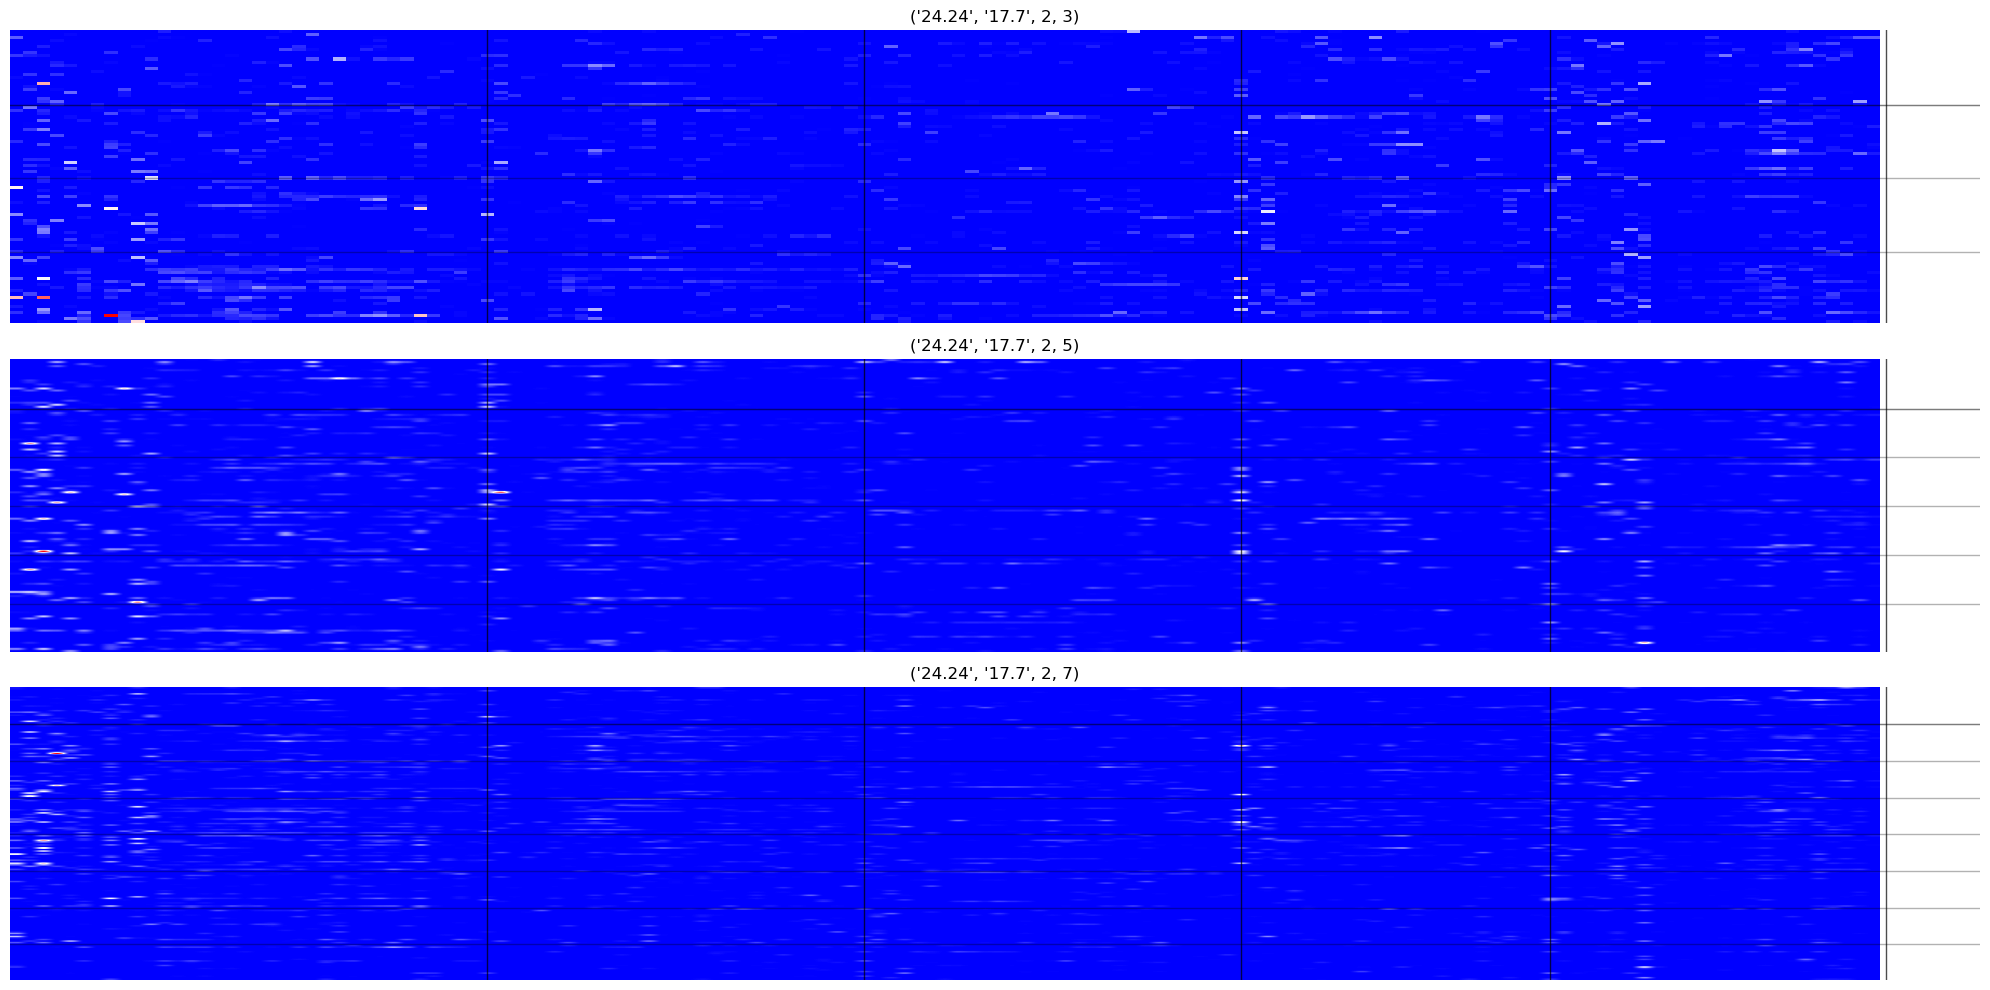

In [288]:
neuron = 0
# plot the readout weights
# color the excitatory weights red and the inhibitory weights blue
fig, axs = plt.subplots(len(center_readout_weights.keys()),1, figsize=(20,10))
for i,k in enumerate(center_readout_weights.keys()):
    num_subunits, filter_widths, num_lags, num_iter = k
    ax = axs.flatten()[i]
    ax.imshow(center_readout_weights[k], cmap='bwr', origin='upper', aspect='auto')
    ax.set_title(k)
    ax.axis('off')

    # put a vertical line between each experiment
    for expt_boundary in expt_boundaries:
        ax.axvline(expt_boundary, color='k', linewidth=1, alpha=0.7)

    # put a horizontal line between each layer
    layer_boundaries = [int(num_subunits.split('.')[0])]
    for layer in range(1, num_iter+1):
        layer_boundaries.append(layer*int(num_subunits.split('.')[1]))
    for layer_boundary in layer_boundaries:
        ax.axhline(layer_boundary, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

# TODO:
# 1) properly color the excitatory and inhibitory weights
# 2) cluster the weights by neuron and experiment 
#    (try the center of space, the mean of space, and the total space) 
# 3) plot the weights in a more interpretable way

In [105]:
import pprint

# get the reg_vals for each trial and plot them compare to the LLs
reg_valses = []
LLs = []
for trial in e.trials:
    reg_vals = []
    for network in trial.model.networks:
        for layer in network.layers:
            if 'reg_vals' in layer.params:
                for k,v in layer.params['reg_vals'].items():
                    if k =='bcs':
                        for k2,v2 in v.items():
                            reg_vals.append(v2)
                    else:
                        reg_vals.append(v)
    reg_valses.append(reg_vals)
    LLs.append(np.mean(trial.LLs))

print(reg_valses[0])
#pprint.pprint(LLs)

[array([0.09760542]), array([0.02992758]), 1, array([0.00215319]), array([0.08978188]), array([0.06255312]), 1, array([0.02356874])]


In [89]:
# filter_width=(17,7) num_subunits=(12,12), num_iter=3  
# 17x14 x 12 --> 7x12 x 12 --> 36*12 + 36*12*3

# 21x10 x 10 --> 36x10x3
model = e.trials_where(trial_idx=5)[0].model
model.NDN.list_parameters()
model.networks[0].layers[0].weights.shape, model.networks[1].layers[0].weights.shape

Network 0:
  Layer 0:
      weight: torch.Size([231, 8])
  Layer 1:
      weight: torch.Size([176, 8])
Network 1:
  Layer 0:
      weight: torch.Size([1152, 49])
      bias: torch.Size([49])


((21, 11, 8), (32, 36, 49))

# reweight the subunits

max:  0.17548232 min:  -0.17548232


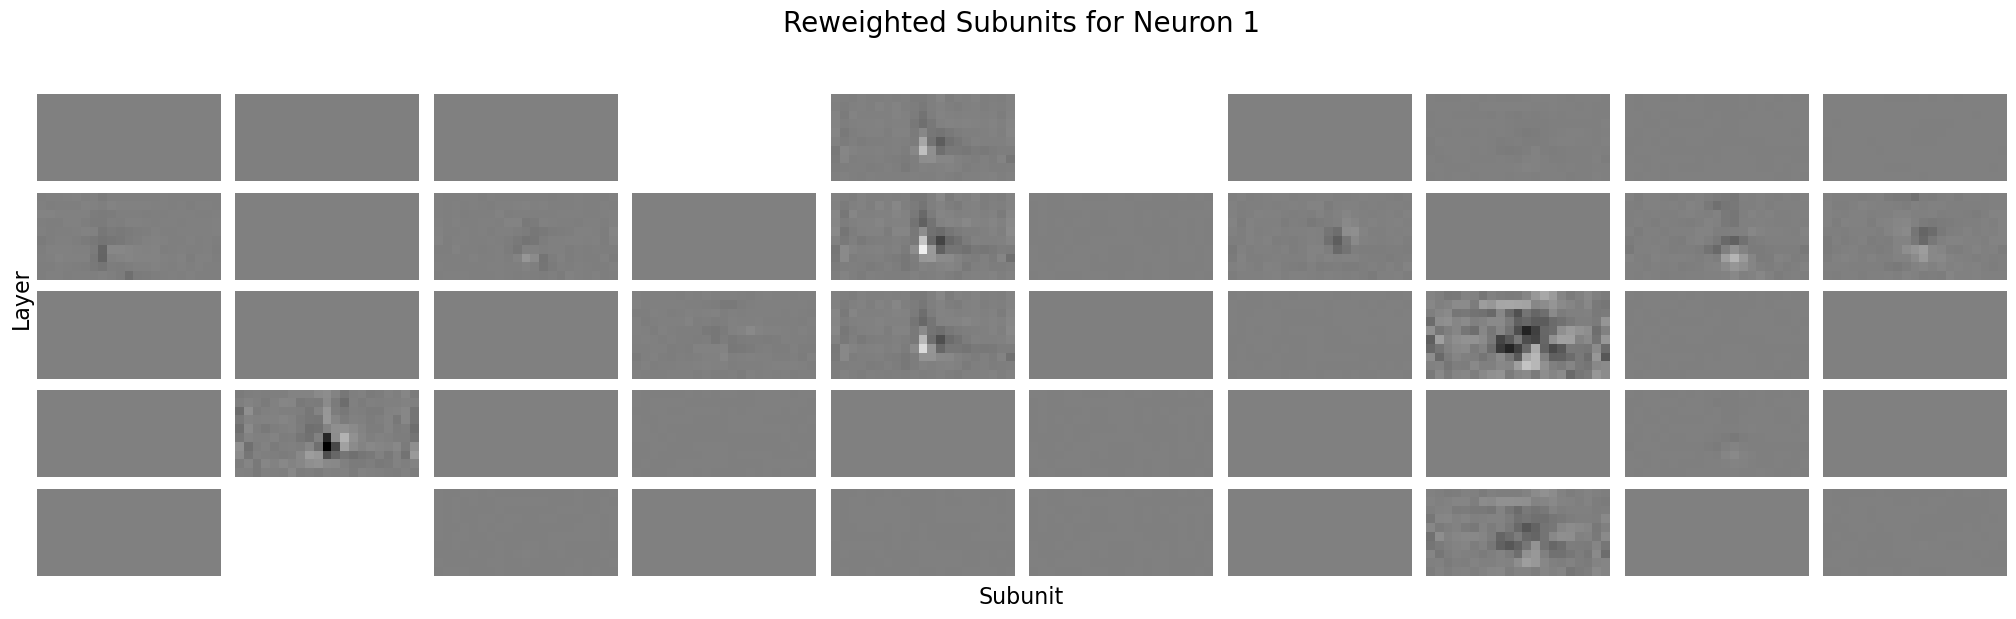

In [107]:
# # reweight the subunits by their connection to the readout layer
# # get the readout layer weights
# readout_weights = model.networks[1].layers[0].weights
# # get the subunit weights
# subunit_weights = model.networks[0].layers[0].weights
# 
# # swap the last and first axes of the subunit weights
# subunit_weights = np.swapaxes(subunit_weights, 0, 2)
# 
# # reweight the subunits
# reweighteds = [] # layer, neuron, subunit
# for neuron in range(11):
#     reweighted_layer = []
#     for layer in range(5):
#         reweighted_neuron = []
#         for i,readout_weight in enumerate(readout_weights[20:30,15,neuron]):
#             reweighted = readout_weight * subunit_weights[i,:,:]
#             reweighted_neuron.append(reweighted)
#         reweighted_layer.append(reweighted_neuron)
#     reweighteds.append(reweighted_layer)
# 
# # get the min and max of the reweighted subunits
# imax = np.max(reweighteds)
# imin = -imax
# print('max: ', imax, 'min: ', imin)
# 
# # plot the reweighted subunits for neuron 1
# fig, axs = plt.subplots(5,10, figsize=(20,6))
# for layer in range(5):
#     for i,reweighted in enumerate(reweighteds[layer][1]):
#         ax = axs[layer,i]
#         ax.imshow(reweighted, cmap='gray', origin='lower', vmin=imin, vmax=imax)
#         ax.axis('off')
# plt.tight_layout()
# plt.suptitle('Reweighted Subunits for Neuron 1', fontsize=20)
# # put spacing between the title and the subplots
# plt.subplots_adjust(top=0.85)
# # label the super axes large font
# fig.text(0.5, 0, 'Subunit', ha='center', va='center', fontsize=16)
# fig.text(0, 0.5, 'Layer', ha='center', va='center', rotation='vertical', fontsize=16)
# plt.show()

# plot the results

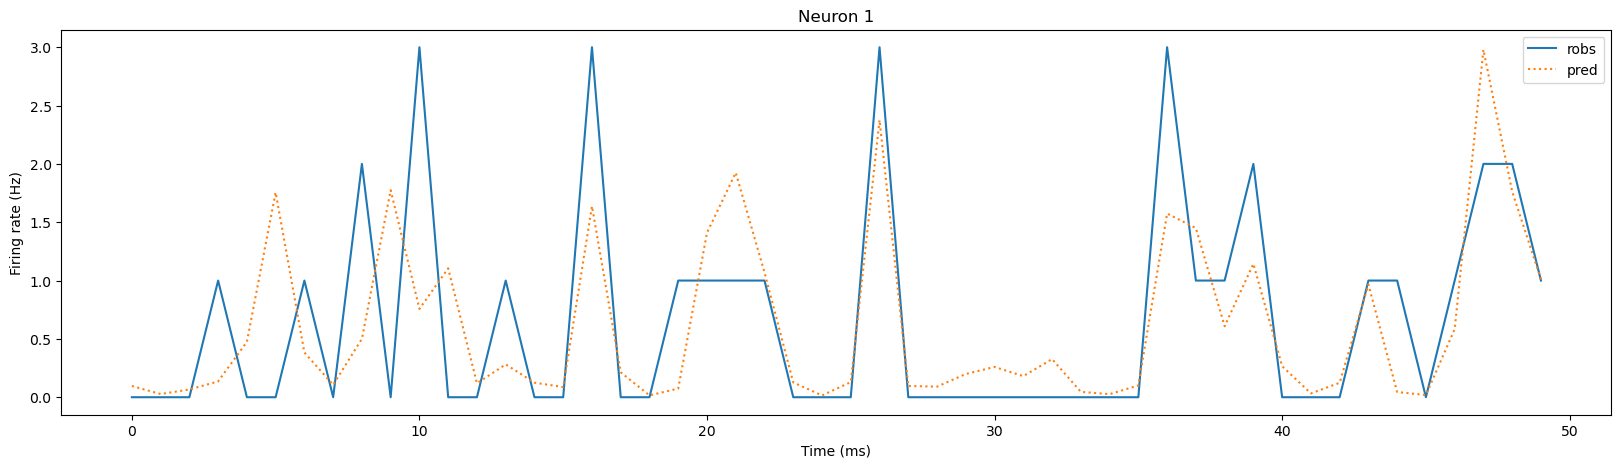

In [92]:
results = predict.predict(e.trials_where(trial_idx=5)[0].model, dataset=e.trials_where(trial_idx=5)[0].dataset[100:150])
plot.plot_robs(results.robs, results.pred, neuron=1, figsize=(20,5))

# explore the Tconv

In [ ]:
# define a model
tconv_layer = m.TemporalConvolutionalLayer(
    num_filters=8,
    num_inh=4,
    filter_dims=[1, 21, 1, 11],
    window='hamming',
    NLtype=m.NL.relu,
    norm_type=m.Norm.unit,
    bias=False,
    initialize_center=True,
    output_norm='batch',
    reg_vals={'d2xt': 0.01, 'center': 0.01, 'bcs': {'d2xt': 1}},
    padding='spatial')

itert_layer = m.IterativeTemporalConvolutionalLayer(
    num_filters=8,
    num_inh=4,
    filter_dims=11,
    num_lags=2,
    window='hamming',
    NLtype=m.NL.relu,
    norm_type=m.Norm.unit,
    bias=False,
    initialize_center=True,
    output_norm='batch',
    num_iter=3,
    output_config='full',
    reg_vals={'activity':0.01, 'd2xt': 0.01, 'center': 0.01, 'bcs': {'d2xt': 1}})

readout_layer = m.Layer(
    pos_constraint=True, # because we have inhibitory subunits on the first layer
    norm_type=m.Norm.none,
    NLtype=m.NL.softplus,
    bias=True,
    initialize_center=True,
    reg_vals={'glocalx': 0.01}
)

inp_stim = m.Input(covariate='stim', input_dims=[1,36,1,14])

core_net = m.Network(layers=[tconv_layer, itert_layer],
                     network_type=m.NetworkType.scaffold,
                     name='core')
readout_net = m.Network(layers=[readout_layer],
                        name='readout')
# this is set as a starting point, but updated on each iteration
output_11 = m.Output(num_neurons=11)

inp_stim.to(core_net)
core_net.to(readout_net)
readout_net.to(output_11)
itert_model = m.Model(output_11, name='tconv_scaffold_iter', create_NDN=False, verbose=True)

# create and run an experiment
experiment = exp.Experiment(name=self.experiment_name,
                            description=self.experiment_desc,
                            generate_trial=lambda prev_trials: self.generate_trial(prev_trials),
                            experiment_location=self.experiment_location,
                            overwrite=self.overwrite_mode)
experiment.run()